In [1]:
import talib as ta
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
from datetime import datetime, timedelta
%matplotlib inline
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')

from pandas_datareader import data as web
import yfinance as yf
yf.pdr_override()

import plotly.graph_objects as go

In [2]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import statsmodels.api as sm
from sklearn import metrics
from sklearn import tree
from xgboost import plot_tree, plot_importance

# Regression Models

## 1.Parameter Assumption and Function Definition

In [3]:
tick = 'ES=F'
original_interval = '1d'  # 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
start_time = datetime.strptime('06/30/2001', '%m/%d/%Y')    
end_time = datetime.strptime('06/30/2021', '%m/%d/%Y')      

In [4]:
def yf_download(tick):
    df = yf.download(tickers = tick, start=start_time,end=end_time, interval = original_interval)
    df.index.name = 'Time'
    return df

In [5]:
def regression_prediction_measure(best_estimator, x_train, x_test, y_train, y_test, alpha = 0.05):
    # Adjusted r square
    rsquare = metrics.r2_score(y_train, best_estimator.predict(x_train))
    adj_rsquare = 1 - ((1-rsquare)*(x_train.shape[0]-1)/(x_train.shape[0]-x_train.shape[1]-1))

    pred = best_estimator.predict(x_test)
    # Mean squared prediction error
    mspe = np.sum((y_test - pred)**2)/len(y_test)
    # Mean absolute prediction error
    mae = np.sum(abs(y_test - pred))/len(y_test)
    # Mean absolute percentage error
    mape = np.sum(abs(y_test[y_test != 0] - pred[y_test != 0])/(y_test[y_test != 0]))/len(y_test[y_test!=0])
    # Precision error
    y_test_mean = np.mean(y_test)
    pm = np.sum((pred - y_test)**2)/np.sum((y_test-y_test_mean)**2)
    # Confidence interval error
    from scipy.stats import t
    n, p = x_train.shape
    df = n - p - 1
    sse = np.sum((y_train - best_estimator.predict(x_train))**2)
    mse = sse/df
    t_critical = t.ppf(1-alpha/2, df)
    interval_lower = pred - t_critical * np.sqrt(mse)
    interval_upper = pred + t_critical * np.sqrt(mse)
    cim = np.sum((pred < interval_lower) | (pred > interval_upper))/len(y_test)
    return {"Adjusted r square": adj_rsquare,
            "Mean squared prediction error": mspe, 
            "Mean absolute prediction error": mae, 
            "Mean absolute percentage error": mape, 
            "Precision error": pm, 
            "Confidence interval error": cim}

## 2. Data Preparation 

### 2.1 Data Download from YahooFinance

In [6]:
es = yf_download(tick)
es['ret'] = es['Close'].pct_change()
es.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,ret
Time,,,,,,,
2001-07-02,1233.50,1248.25,1229.00,1246.00,1246.00,57913,NaN
2001-07-03,1246.00,1247.25,1235.75,1245.25,1245.25,57913,-0.000602
2001-07-05,1245.25,1245.25,1221.50,1222.25,1222.25,70416,-0.018470
2001-07-06,1222.00,1223.50,1193.00,1193.50,1193.50,128218,-0.023522
2001-07-09,1194.50,1209.25,1189.00,1200.75,1200.75,139075,0.006075


Text(0.5, 1.0, 'E-mini S&P 500 Future Main')

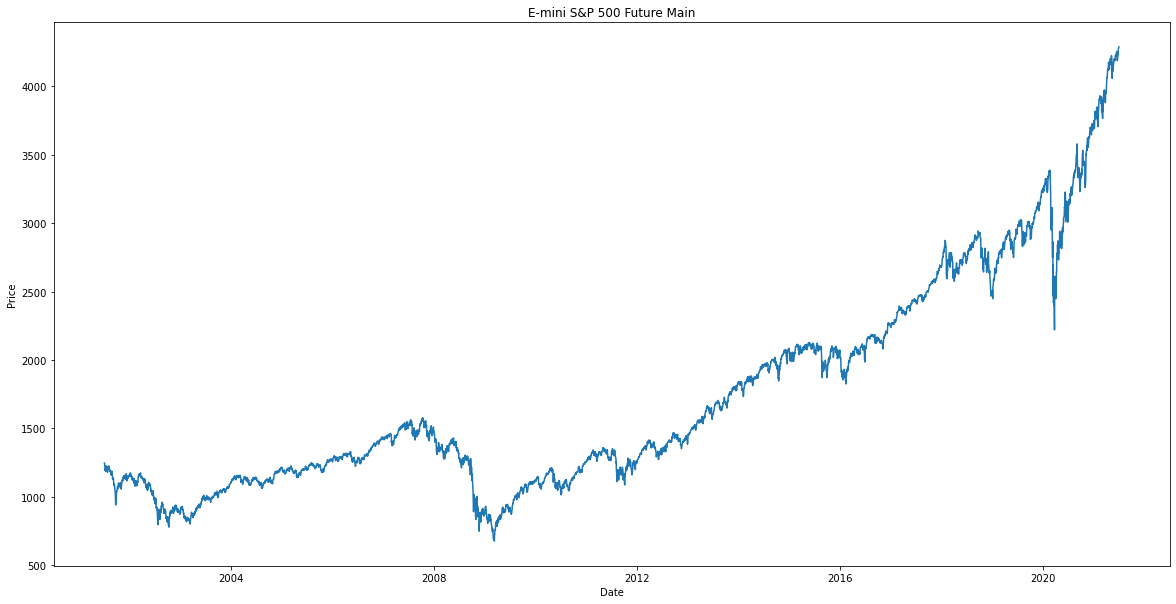

In [7]:
plt.figure(figsize = (20,10))
plt.plot(es.index, es['Close'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('E-mini S&P 500 Future Main')
#plt.savefig('C:/Users/Renane/Desktop/AQF/代码_RW Use/Stock Data/Factor Investing/ESmain 2001-2021.png')

### 2.2 Data Import

In [8]:
ff_5fac = pd.read_csv('C:/Users/Renane/Desktop/AQF/代码_RW Use/Stock Data/Factor Investing/F-F_Research_Data_5_Factors_2x3_daily.csv')
ff_5fac.rename(columns = {'Unnamed: 0': 'date'}, inplace = True)
ff_5fac['date'] = ff_5fac['date'].apply(lambda s: datetime.strptime(str(s), '%Y%m%d'))
ff_5fac = ff_5fac[ff_5fac['date'] >= start_time]
ff_5fac.head()

,date,Mkt-RF,SMB,HML,RMW,CMA,RF
9569,2001-07-02,0.56,-3.19,1.36,0.99,0.59,0.014
9570,2001-07-03,-0.21,-0.05,0.12,0.32,0.34,0.014
9571,2001-07-05,-1.24,0.52,0.34,1.32,0.95,0.014
9572,2001-07-06,-2.29,0.55,0.93,0.46,1.05,0.014
9573,2001-07-09,0.59,-0.19,0.74,-0.41,-0.32,0.014


In [9]:
ff_rev = pd.read_csv('C:/Users/Renane/Desktop/AQF/代码_RW Use/Stock Data/Factor Investing/F-F_ST_Reversal_Factor_daily.csv')
ff_rev.rename(columns = {'Unnamed: 0': 'date'}, inplace = True)
ff_rev.dropna(axis = 0, inplace = True)
ff_rev['date'] = ff_rev['date'].apply(lambda s: datetime.strptime(str(s), '%Y%m%d'))
ff_rev = ff_rev[ff_rev['date']>=start_time]
ff_rev.head()

,date,ST_Rev
20118,2001-07-02,1.49
20119,2001-07-03,0.21
20120,2001-07-05,-0.07
20121,2001-07-06,-0.71
20122,2001-07-09,-0.17


In [10]:
ff_mom = pd.read_csv('C:/Users/Renane/Desktop/AQF/代码_RW Use/Stock Data/Factor Investing/F-F_Momentum_Factor_daily.csv')
ff_mom.rename(columns = {'Unnamed: 0': 'date'}, inplace = True)
ff_mom['date'] = ff_mom['date'].apply(lambda s: datetime.strptime(str(s), '%Y%m%d'))
ff_mom = ff_mom[ff_mom['date']>=start_time]
ff_mom.head()

,date,Mom
19888,2001-07-02,0.14
19889,2001-07-03,0.43
19890,2001-07-05,1.72
19891,2001-07-06,1.55
19892,2001-07-09,-0.64


### 2.3 Data Merge

In [11]:
df_merge = es[['ret', 'Volume']].merge(ff_5fac, how = 'left', left_index = True, right_on = 'date')
df_merge = df_merge.merge(ff_mom, how = 'left', left_on = 'date', right_on = 'date')
df_merge = df_merge.merge(ff_rev, how = 'left', left_on = 'date', right_on = 'date')
df_merge['ret-rf'] = df_merge.apply(lambda row: row['ret'] - row['RF'], axis = 1)
df_merge.columns = ['ret','Volume', 'date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF','MOM', 'ST_Rev', 'ret-rf']
df_merge = df_merge.iloc[1:]
df_merge.head()

,ret,Volume,date,Mkt-RF,SMB,HML,RMW,CMA,RF,MOM,ST_Rev,ret-rf
1,-0.000602,57913,2001-07-03,-0.21,-0.05,0.12,0.32,0.34,0.014,0.43,0.21,-0.014602
2,-0.018470,70416,2001-07-05,-1.24,0.52,0.34,1.32,0.95,0.014,1.72,-0.07,-0.032470
3,-0.023522,128218,2001-07-06,-2.29,0.55,0.93,0.46,1.05,0.014,1.55,-0.71,-0.037522
4,0.006075,139075,2001-07-09,0.59,-0.19,0.74,-0.41,-0.32,0.014,-0.64,-0.17,-0.007925
5,-0.011868,164772,2001-07-10,-1.49,-0.04,1.98,0.92,0.65,0.014,1.70,-1.34,-0.025868


## 3.Exploratory Analysis

### 3.1 Check Missing Values

In [12]:
for col in ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM', 'ST_Rev']:
    print(np.where(df_merge[col].isin([-99.99, -999])))        # Missing data are indicated by -99.99 or -999. 

(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)


In [14]:
missing_cols = df_merge.columns[df_merge.isnull().any()]
for col in list(missing_cols):
    print('Missing locations for {}: {}.'.format(col, df_merge[df_merge[col].isnull()].index))
    
# Rows with NaN values 
df_merge[df_merge.isna().any(axis = 1)].head()

Missing locations for Mkt-RF: Int64Index([  49,  156,  225,  253,  295,  358,  393,  413,  482,  551,  614,
             649,  669,  743,  752,  768,  813,  871, 1123, 1158, 1183, 1252,
            1277, 1321, 1379],
           dtype='int64').
Missing locations for SMB: Int64Index([  49,  156,  225,  253,  295,  358,  393,  413,  482,  551,  614,
             649,  669,  743,  752,  768,  813,  871, 1123, 1158, 1183, 1252,
            1277, 1321, 1379],
           dtype='int64').
Missing locations for HML: Int64Index([  49,  156,  225,  253,  295,  358,  393,  413,  482,  551,  614,
             649,  669,  743,  752,  768,  813,  871, 1123, 1158, 1183, 1252,
            1277, 1321, 1379],
           dtype='int64').
Missing locations for RMW: Int64Index([  49,  156,  225,  253,  295,  358,  393,  413,  482,  551,  614,
             649,  669,  743,  752,  768,  813,  871, 1123, 1158, 1183, 1252,
            1277, 1321, 1379],
           dtype='int64').
Missing locations for CMA: Int64I

,ret,Volume,date,Mkt-RF,SMB,HML,RMW,CMA,RF,MOM,ST_Rev,ret-rf
49,0.000000,0,2001-09-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
156,0.000000,221738,2002-02-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
225,0.002771,248708,2002-05-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
253,-0.000525,417776,2002-07-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
295,-0.004111,286234,2002-09-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# Interpolate np.nan 
df_merge[ ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'MOM', 'ST_Rev']] = df_merge[ ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF','MOM', 'ST_Rev']].interpolate(method = 'linear', axis = 0)
df_merge['ret-rf'] = df_merge.apply(lambda row: row['ret'] - row['RF'], axis = 1)

df_merge.head()

,ret,Volume,date,Mkt-RF,SMB,HML,RMW,CMA,RF,MOM,ST_Rev,ret-rf
1,-0.000602,57913,2001-07-03,-0.21,-0.05,0.12,0.32,0.34,0.014,0.43,0.21,-0.014602
2,-0.018470,70416,2001-07-05,-1.24,0.52,0.34,1.32,0.95,0.014,1.72,-0.07,-0.032470
3,-0.023522,128218,2001-07-06,-2.29,0.55,0.93,0.46,1.05,0.014,1.55,-0.71,-0.037522
4,0.006075,139075,2001-07-09,0.59,-0.19,0.74,-0.41,-0.32,0.014,-0.64,-0.17,-0.007925
5,-0.011868,164772,2001-07-10,-1.49,-0.04,1.98,0.92,0.65,0.014,1.70,-1.34,-0.025868


### 3.2 Explore the Distribution of All Variables

Text(0.5, 1.0, 'Histogram of ST_Rev')

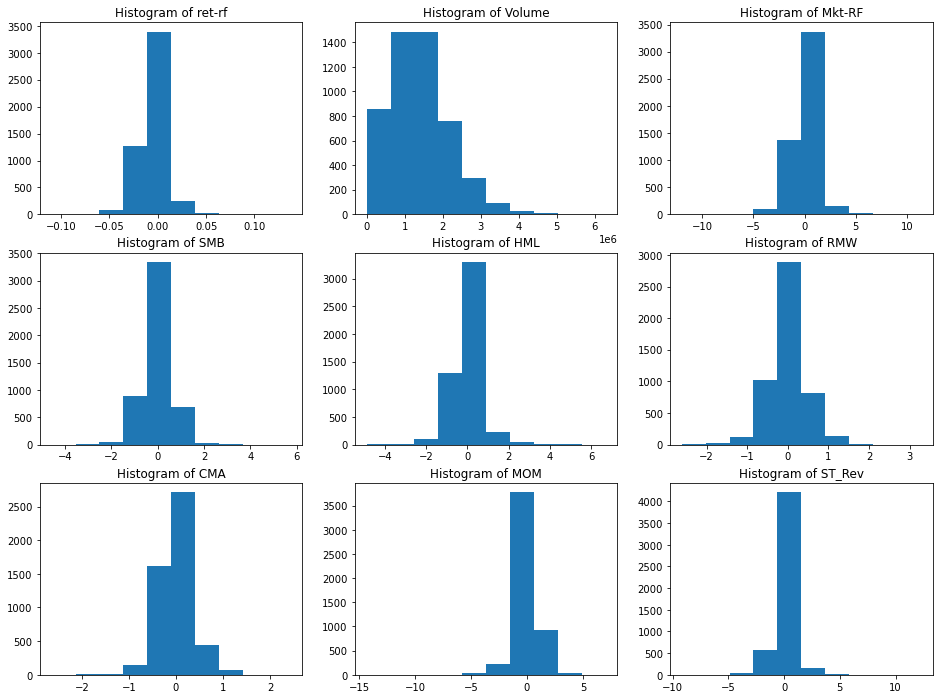

In [16]:
fig, axs = plt.subplots(3, 3,figsize = (16,12))
axs[0,0].hist(x = df_merge['ret-rf'])
axs[0,0].set_title('Histogram of ret-rf')
axs[0,1].hist(x = df_merge['Volume'])
axs[0,1].set_title('Histogram of Volume')
axs[0,2].hist(x = df_merge['Mkt-RF'])
axs[0,2].set_title('Histogram of Mkt-RF')
axs[1,0].hist(x = df_merge['SMB'])
axs[1,0].set_title('Histogram of SMB')
axs[1,1].hist(x = df_merge['HML'])
axs[1,1].set_title('Histogram of HML')
axs[1,2].hist(x = df_merge['RMW'])
axs[1,2].set_title('Histogram of RMW')
axs[2,0].hist(x = df_merge['CMA'])
axs[2,0].set_title('Histogram of CMA')
axs[2,1].hist(x = df_merge['MOM'])
axs[2,1].set_title('Histogram of MOM')
axs[2,2].hist(x = df_merge['ST_Rev'])
axs[2,2].set_title('Histogram of ST_Rev')

### 3.3 Explore the Relationship among All Variables

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000219E8D02220>,
      dtype=object)

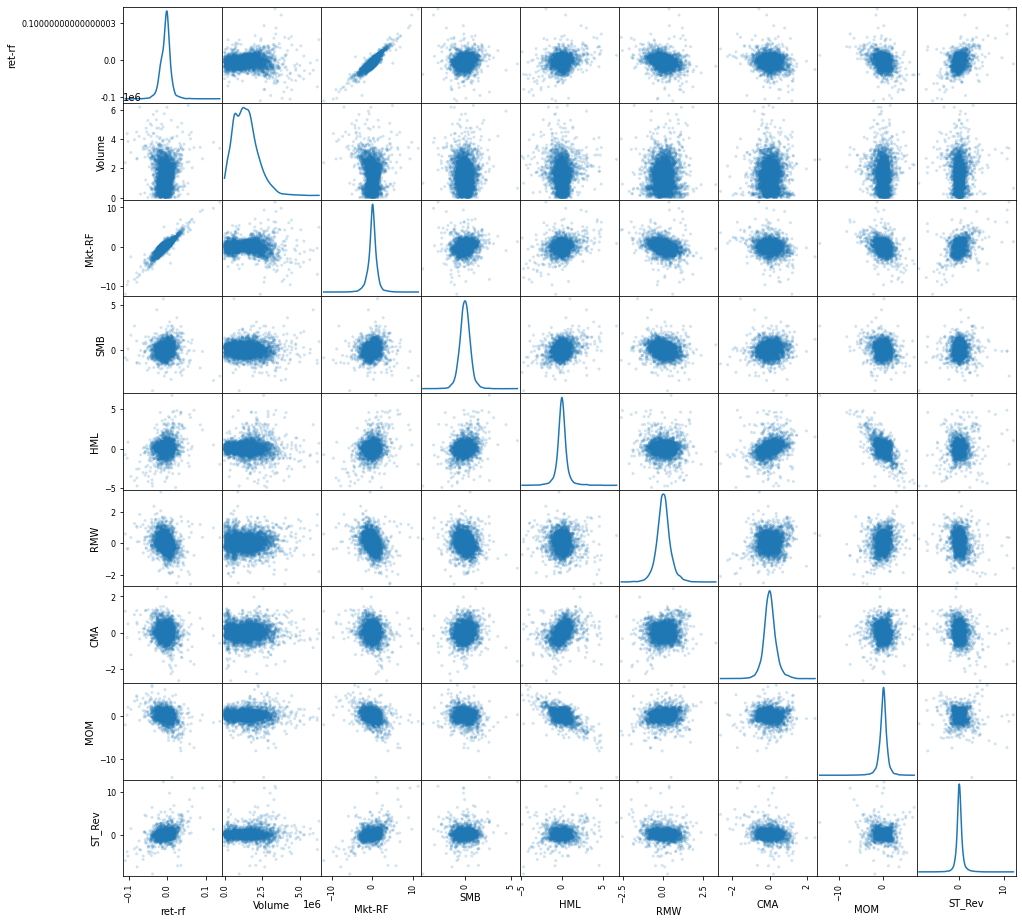

In [17]:
from pandas.plotting import scatter_matrix
scatter_matrix(df_merge[['ret-rf','Volume', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM', 'ST_Rev']], 
               alpha = 0.2, figsize = (16, 16), diagonal = 'kde')

### 3.4 Explore the Correlation Coefficients

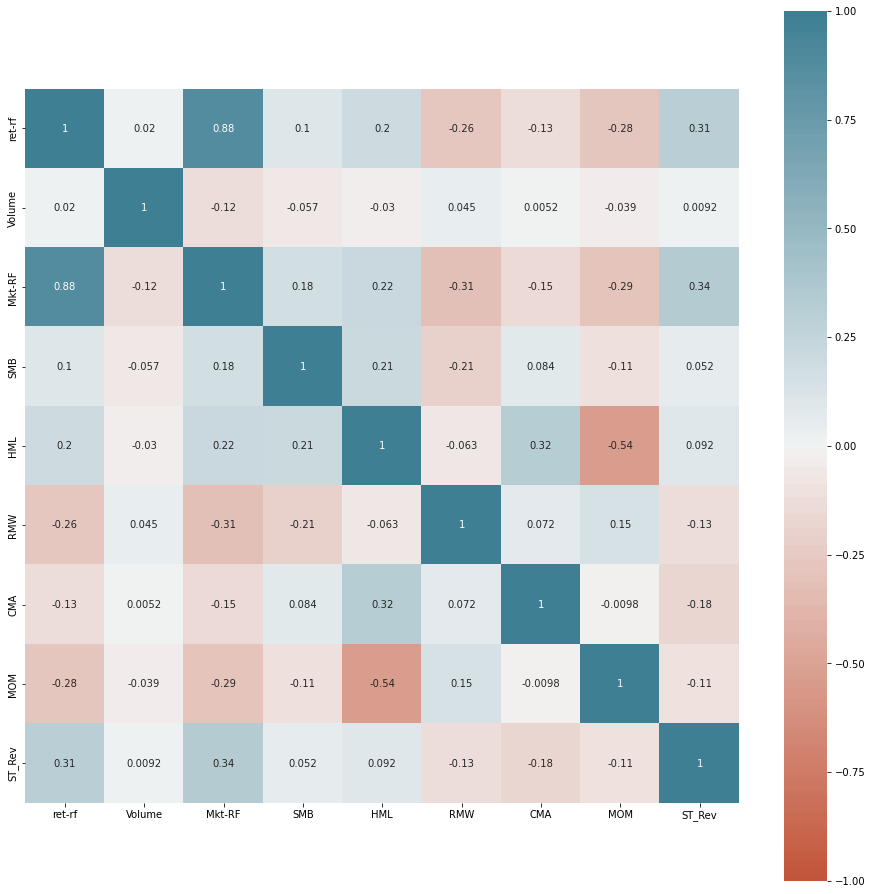

In [18]:
corr = df_merge[['ret-rf','Volume', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM', 'ST_Rev']].corr()
fig, ax = plt.subplots(figsize=(16,16))
ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0,
                cmap=sns.diverging_palette(20, 220, n=200),
                square=True, annot = True)

### 3.5 Summary Statistics

In [19]:
df_merge[['ret-rf','Volume', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM', 'ST_Rev']].describe()

,ret-rf,Volume,Mkt-RF,SMB,HML,RMW,CMA,MOM,ST_Rev
count,5020.000000,5.020000e+03,5020.000000,5020.000000,5020.000000,5020.000000,5020.000000,5020.000000,5020.000000
mean,-0.004596,1.399900e+06,0.036332,0.009214,-0.001428,0.015234,0.005625,0.007886,0.038043
std,0.013809,8.075740e+05,1.236906,0.608079,0.719941,0.443731,0.350454,1.027891,0.935750
min,-0.109765,0.000000e+00,-12.000000,-4.580000,-4.890000,-2.610000,-2.640000,-14.310000,-9.170000
25%,-0.011971,7.813910e+05,-0.460000,-0.340000,-0.300000,-0.230000,-0.190000,-0.410000,-0.310000
50%,-0.003460,1.322248e+06,0.080000,0.010000,-0.010000,0.010000,0.000000,0.060000,-0.010000
75%,0.002554,1.850585e+06,0.590000,0.360000,0.280000,0.250000,0.190000,0.470000,0.320000
max,0.137134,6.285917e+06,11.350000,5.730000,6.700000,3.270000,2.430000,7.010000,12.240000


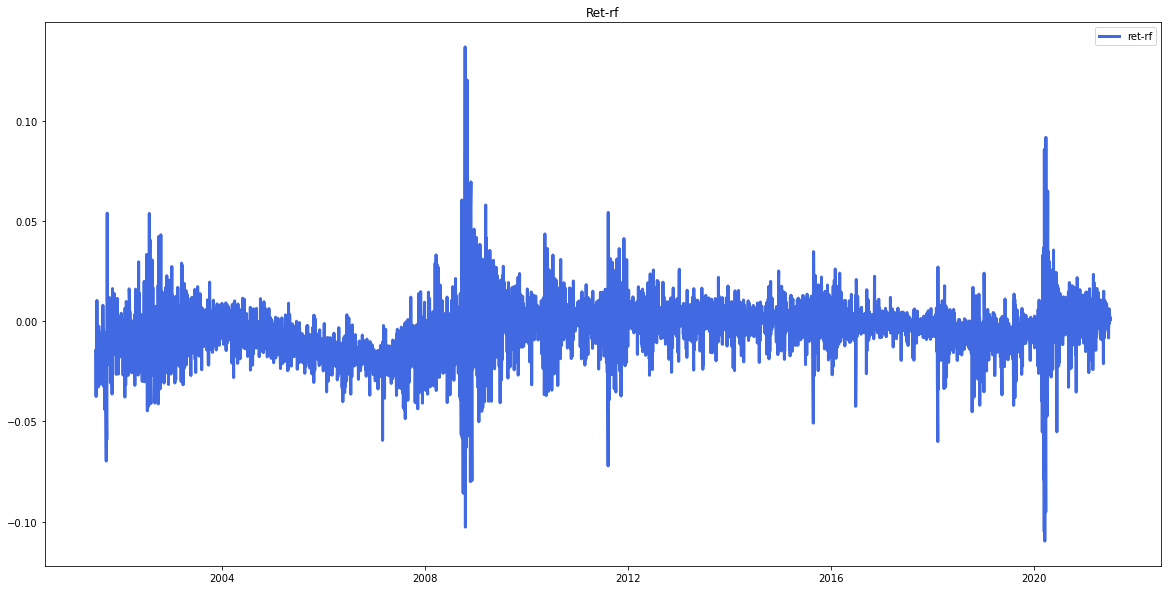

In [20]:
plt.figure(figsize = (20, 10))
plt.plot(df_merge['date'], df_merge['ret-rf'], label = 'ret-rf', linestyle="-", linewidth=3, color = 'royalblue')
plt.title("Ret-rf")
plt.legend()
plt.show()

## 4. Feature Engineering

### 4.1 Baseline

In [21]:
x_merge = df_merge[['Volume', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM', 'ST_Rev']]
y_merge = df_merge['ret-rf']
x_merge2 = sm.add_constant(x_merge)
m2 = sm.OLS(y_merge, x_merge2).fit()
m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 ret-rf   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     2317.
Date:                Tue, 02 Nov 2021   Prob (F-statistic):               0.00
Time:                        15:01:15   Log-Likelihood:                 18259.
No. Observations:                5020   AIC:                        -3.650e+04
Df Residuals:                    5011   BIC:                        -3.644e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0080      0.000    -43.677      0.000      -0.008      -0.008
Volume      2.143e-09   1.13e-10     18.968      0.000    1.92e-09    2.36e-09
Mkt-RF         0.0100   8.55e-05    117.116      0.000       0.010       0.010
SMB           -0.0011      0.000     -7.132      0.000      -0.001      -0.001
HML        -2.133e-05      0.000     -0.130      0.897      -0.000       0.000
RMW            0.0003      0.000      1.286      0.199      -0.000       0.001
CMA            0.0005      0.000      1.842      0.065   -3.39e-05       0.001
MOM           -0.0002      0.000     -1.667      0.096      -0.000    3.18e-05
ST_Rev         0.0002      0.000      1.842      0.066   -1.22e-05       0.000
==============================================================================
Omnibus:                     1298.895   Durbin-Watson:                   0.703
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6323.099
Skew:                          -1.163   Prob(JB):                         0.00
Kurtosis:                       7.982   Cond. No.                     5.37e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.37e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 4.2 Model Assessment

#### 4.2.1 Check Outliers

In [22]:
# Compute the influence to get Cook's distance
from statsmodels.stats.outliers_influence import OLSInfluence as influence
inf = influence(m2)
C, P = inf.cooks_distance    # C: cook's distance, P: p value
C

1       0.000073
2       0.001866
3       0.000453
4       0.000161
5       0.000182
          ...   
5016    0.000088
5017    0.000060
5018    0.000193
5019    0.000094
5020    0.000204
Length: 5020, dtype: float64

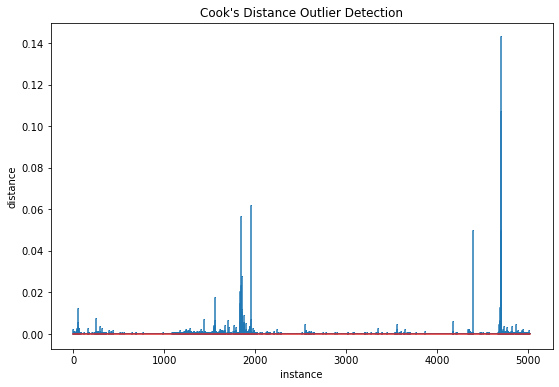

In [23]:
def plot_cooks_distance(c):
    _, ax = plt.subplots(figsize=(9,6))
    ax.stem(c, markerfmt=",")
    ax.set_xlabel("instance")
    ax.set_ylabel("distance")
    ax.set_title("Cook's Distance Outlier Detection")
    return ax


plot_cooks_distance(C)    # No outliers

In [24]:
outlier_idx = np.where(C>=1)
outlier_idx      # No outliers

(array([], dtype=int64),)

#### 4.2.2 Check Multicollinearity

In [25]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data['Feature'] = x_merge.columns
vif_data['VIF'] = [variance_inflation_factor(x_merge.values, i) for i in range(len(x_merge.columns))]
vif_data

,Feature,VIF
0,Volume,1.008677
1,Mkt-RF,1.359741
2,SMB,1.103767
3,HML,1.731189
4,RMW,1.151140
5,CMA,1.251704
6,MOM,1.524483
7,ST_Rev,1.161134


In [27]:
vif_threshold = max(10, 1/(1-m2.rsquared))
vif_threshold                                    

# no multicollinearity indicated by vif 

10

#### 4.2.3 Goodness of Fit

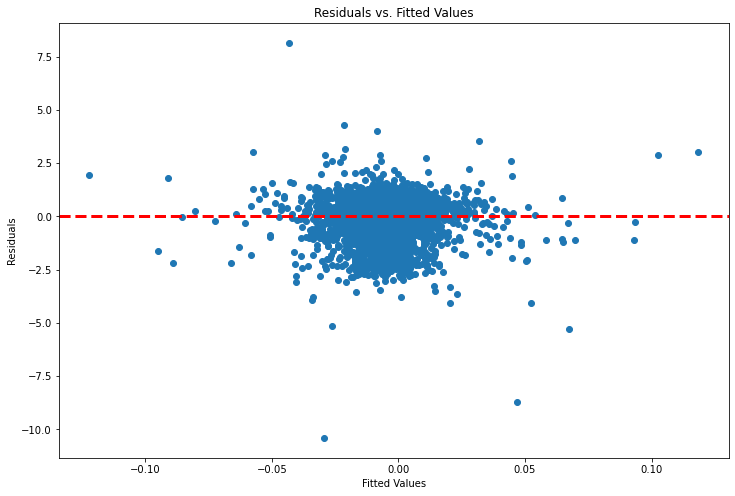

In [28]:
# Constant Variance Assumption
resid2_inf = m2.get_influence()
std_resid2 = resid2_inf.resid_studentized_internal
pred2 = m2.predict(x_merge2)


plt.figure(figsize = (12,8))
plt.scatter(x = pred2, y = std_resid2)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.axhline(y = 0, color = 'red', linestyle = '--', linewidth = 3)

Text(0.5, 1.0, 'Residuals vs. ST_Rev')

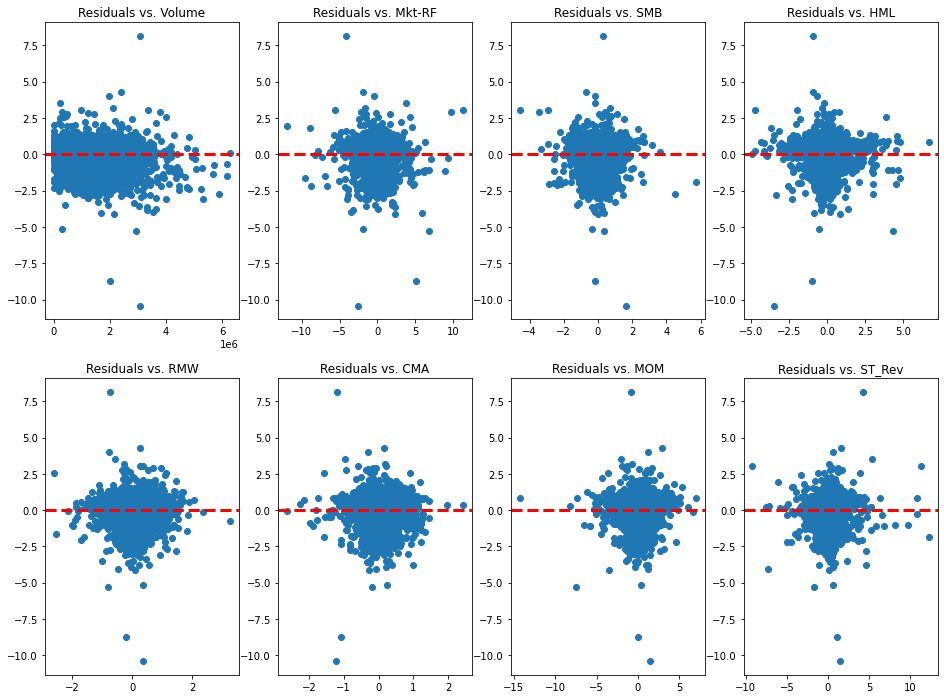

In [29]:
# Linearity Assumption
fig, ax = plt.subplots(2,4, figsize = (16,12))
ax[0,0].scatter(x_merge['Volume'], std_resid2)
ax[0,0].axhline(y = 0, color = 'red', linestyle = '--', linewidth = 3)
ax[0,0].set_title('Residuals vs. Volume')
ax[0,1].scatter(x_merge['Mkt-RF'], std_resid2)
ax[0,1].axhline(y = 0, color = 'red', linestyle = '--', linewidth = 3)
ax[0,1].set_title('Residuals vs. Mkt-RF')
ax[0,2].scatter(x_merge['SMB'], std_resid2)
ax[0,2].axhline(y = 0, color = 'red', linestyle = '--', linewidth = 3)
ax[0,2].set_title('Residuals vs. SMB')
ax[0,3].scatter(x_merge['HML'], std_resid2)
ax[0,3].axhline(y = 0, color = 'red', linestyle = '--', linewidth = 3)
ax[0,3].set_title('Residuals vs. HML')
ax[1,0].scatter(x_merge['RMW'], std_resid2)
ax[1,0].axhline(y = 0, color = 'red', linestyle = '--', linewidth = 3)
ax[1,0].set_title('Residuals vs. RMW')
ax[1,1].scatter(x_merge['CMA'], std_resid2)
ax[1,1].axhline(y = 0, color = 'red', linestyle = '--', linewidth = 3)
ax[1,1].set_title('Residuals vs. CMA')
ax[1,2].scatter(x_merge['MOM'], std_resid2)
ax[1,2].axhline(y = 0, color = 'red', linestyle = '--', linewidth = 3)
ax[1,2].set_title('Residuals vs. MOM')
ax[1,3].scatter(x_merge['ST_Rev'], std_resid2)
ax[1,3].axhline(y = 0, color = 'red', linestyle = '--', linewidth = 3)
ax[1,3].set_title('Residuals vs. ST_Rev')

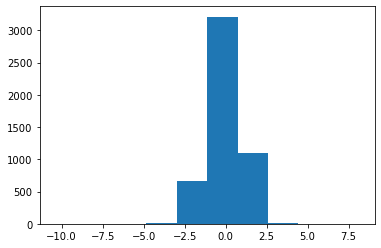

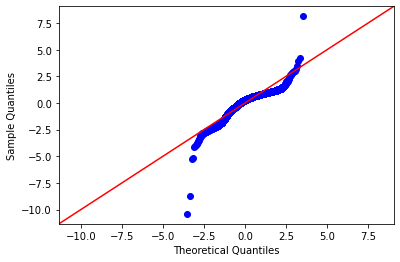

In [30]:
# Normality Assumption
plt.hist(x = std_resid2)
sm.qqplot(std_resid2, line = '45')
plt.show()

### 4.3 BoxCox Transformation

(array([  91.,  272.,  734., 1108., 1448.,  923.,  345.,   71.,   19.,
           9.]),
 array([    0.        ,  1055.07134689,  2110.14269377,  3165.21404066,
         4220.28538754,  5275.35673443,  6330.42808131,  7385.4994282 ,
         8440.57077509,  9495.64212197, 10550.71346886]),
 <a list of 10 Patch objects>)

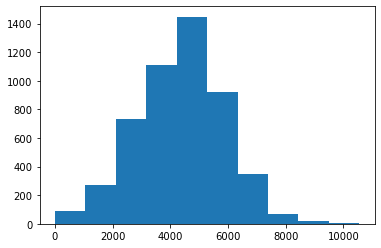

In [31]:
from scipy.stats import boxcox
bc, lamb = boxcox(df_merge['Volume']+1)
plt.hist(bc)

### 4.4 Standardization and Normalization

In [32]:
x_merge['Volume'] = bc
x_train, x_test, y_train, y_test = train_test_split(x_merge, y_merge, test_size = 0.2, random_state = 42)
scaler = StandardScaler()
x_train_sca = scaler.fit_transform(x_train)
x_test_sca = scaler.fit_transform(x_test)
x_train

,Volume,Mkt-RF,SMB,HML,RMW,CMA,MOM,ST_Rev
151,1672.443991,1.33,-0.39,-0.42,0.14,-0.45,-0.66,0.83
2095,4455.461106,0.59,0.56,-0.21,-0.14,0.07,0.07,0.40
3993,6758.748910,-1.97,-0.96,-0.52,0.52,0.29,-1.53,1.16
3306,3522.107228,0.49,-0.12,-0.08,0.26,-0.12,-0.03,-0.09
1492,5037.179987,-1.42,-0.50,0.27,0.01,0.03,0.17,0.20
...,...,...,...,...,...,...,...,...
4427,5076.243455,-0.21,0.53,-0.57,0.40,-0.16,0.05,0.03
467,2837.506370,-0.19,0.79,-0.39,-0.65,0.18,-0.80,-0.11
3093,6309.613924,-0.05,-0.35,0.61,0.46,0.35,-0.23,0.34
3773,5693.244481,1.80,0.31,-0.04,-0.13,-0.26,-0.70,1.13


## 5. Multiple Linear Regression

### 5.1 Model

In [33]:
pca = PCA()
lr = LinearRegression()
lr_pipe = Pipeline([('pca', pca), ('lr', lr)])
param_grid = {'pca__n_components': np.arange(1, x_train.shape[1]+1)}
lr_cv = GridSearchCV(estimator = lr_pipe, param_grid = param_grid, cv = 20)
lr_cv.fit(x_train_sca, y_train)
print(lr_cv.best_estimator_)

Pipeline(steps=[('pca', PCA(n_components=8)), ('lr', LinearRegression())])


In [34]:
lr_cv.best_estimator_.named_steps['lr'].coef_

array([ 5.67355127e-03,  3.88597537e-03,  2.21935824e-03, -5.52856600e-04,
        1.26736459e-05, -1.83499411e-03,  1.00526494e-02, -2.51327700e-04])

### 5.2 Accuracy Measure

In [35]:
accuracy_lr = regression_prediction_measure(lr_cv.best_estimator_, x_train_sca, x_test_sca, y_train, y_test, alpha = 0.05)
accuracy_lr

{'Adjusted r square': 0.7987348725521533,
 'Mean squared prediction error': 4.946124384166554e-05,
 'Mean absolute prediction error': 0.005008596434822795,
 'Mean absolute percentage error': 0.10880448319121744,
 'Precision error': 0.2552829492357458,
 'Confidence interval error': 0.0}

## 6. XGBoost

### 6.1 Model

In [36]:
xgb = xgb.XGBRegressor()
param_grid = {'min_child_weight':[4,5], 
#              'gamma':[i/10.0 for i in range(3,6)],  
#              'learning_rate': [.03, 0.05, .07],
              'subsample':[i/10.0 for i in range(6,11)],
#              'colsample_bytree':[i/10.0 for i in range(6,11)], 
              'max_depth': [5, 6, 7]}
xgb_cv = GridSearchCV(estimator = xgb, param_grid = param_grid, cv = 20)
xgb_cv.fit(x_train, y_train)
print("Best params: ", xgb_cv.best_params_)
print("Best score: ", xgb_cv.best_score_)

Best params:  {'max_depth': 5, 'min_child_weight': 4, 'subsample': 0.9}
Best score:  0.7771332361243314


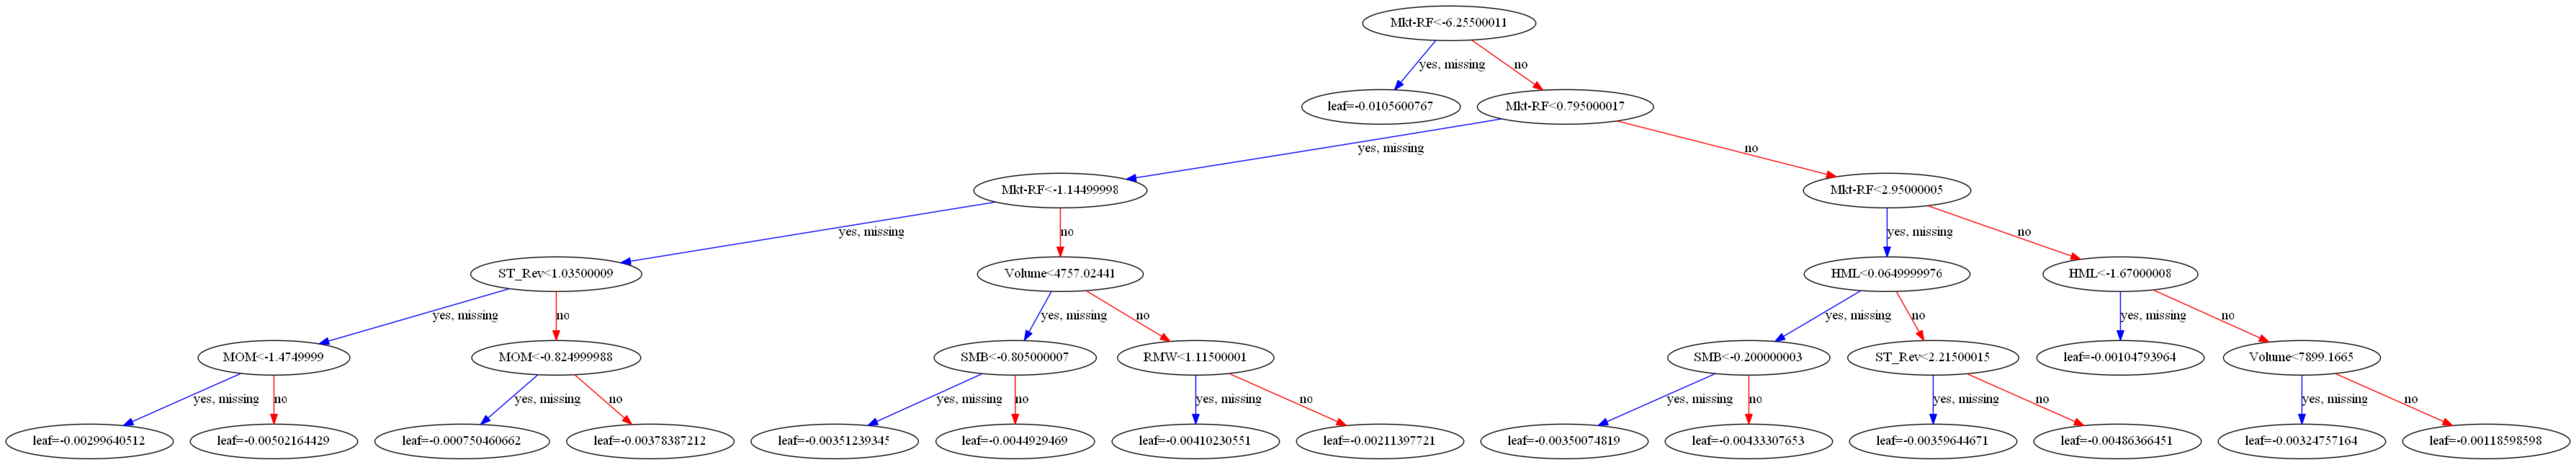

In [39]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Users/Renane/anaconda3/Library/bin/graphviz'

from xgboost import plot_tree, plot_importance
plot_tree(xgb_cv.best_estimator_, num_trees= 10)
fig = plt.gcf()
fig.set_size_inches(150, 100)
plt.show()

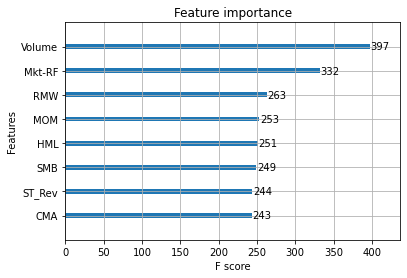

In [40]:
plot_importance(xgb_cv.best_estimator_)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()                                               # number of times a feature appears in a tree

### 6.2 Accuracy Measure

In [41]:
accuracy_xgb = regression_prediction_measure(xgb_cv.best_estimator_, x_train, x_test, y_train, y_test, alpha = 0.05)
accuracy_xgb

{'Adjusted r square': 0.9432412511598678,
 'Mean squared prediction error': 5.247189336544319e-05,
 'Mean absolute prediction error': 0.00520254461518575,
 'Mean absolute percentage error': 0.4524840393862401,
 'Precision error': 0.2708217313174394,
 'Confidence interval error': 0.0}

## 7. Random Forest

### 7.1 Model

In [42]:
rf = RandomForestRegressor()
pca = PCA()
rf_pipe = Pipeline([('pca', pca), ('rf', rf)])
param_grid = {'pca__n_components': np.arange(1, x_train.shape[1]+1),
              'rf__max_depth': [5, 6, 7], 
              'rf__min_samples_leaf': np.arange(10, 50, 10)}
rf_cv = GridSearchCV(estimator = rf_pipe, param_grid = param_grid, cv = 20)
rf_cv.fit(x_train, y_train)
print("Best params: ", rf_cv.best_params_)
print("Best score: ", rf_cv.best_score_)

Best params:  {'pca__n_components': 7, 'rf__max_depth': 7, 'rf__min_samples_leaf': 10}
Best score:  0.7457837174611269


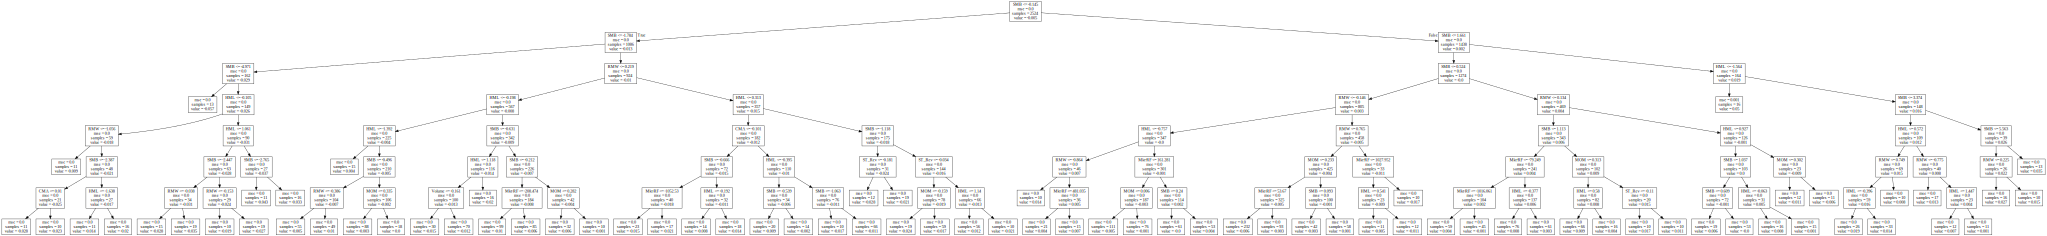

In [43]:
from sklearn.tree import export_graphviz
from graphviz import Source

pca = PCA(n_components = 8).fit_transform(x_train)
forest_clf = RandomForestRegressor(max_depth = 7, min_samples_leaf=10).fit(pca, y_train)

from IPython.display import SVG
graph = Source(export_graphviz(forest_clf.estimators_[0], out_file=None, feature_names=['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM', 'ST_Rev', 'Volume']))
SVG(graph.pipe(format='svg'))

### 7.2 Accuracy Measure

In [44]:
accuracy_rf = regression_prediction_measure(rf_cv.best_estimator_, x_train, x_test, y_train, y_test, alpha = 0.05)
accuracy_rf

{'Adjusted r square': 0.7991868203593047,
 'Mean squared prediction error': 6.075858752228584e-05,
 'Mean absolute prediction error': 0.00550113098971153,
 'Mean absolute percentage error': 0.34478020868924913,
 'Precision error': 0.31359161657437634,
 'Confidence interval error': 0.0}

## 8. Decision Tree

### 8.1 Model

In [45]:
dt = DecisionTreeRegressor()
pca = PCA()
dt_pipe = Pipeline([('pca', pca), ('dt', dt)])
param_grid = {'pca__n_components': np.arange(1, x_train.shape[1]+1),
              'dt__max_depth': [5, 6, 7, 8, 9], 
              'dt__min_samples_leaf': np.arange(10, 50, 10)}
dt_cv = GridSearchCV(estimator = dt_pipe, param_grid = param_grid, cv = 20)
dt_cv.fit(x_train, y_train)
print("Best params: ", dt_cv.best_params_)
print("Best score: ", dt_cv.best_score_)

Best params:  {'dt__max_depth': 8, 'dt__min_samples_leaf': 10, 'pca__n_components': 4}
Best score:  0.7034661205255736


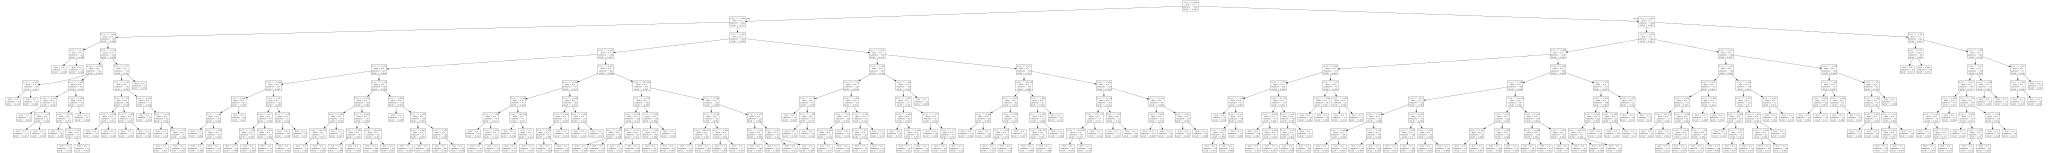

In [46]:
from IPython.display import SVG
pca = PCA(n_components = 7).fit_transform(x_train)
dt = DecisionTreeRegressor(max_depth = 9, min_samples_leaf=10).fit(pca, y_train)

graph = Source(export_graphviz(dt, out_file=None))
SVG(graph.pipe(format='svg'))

### 8.2 Accuracy Measure

In [47]:
accuracy_dt = regression_prediction_measure(dt_cv.best_estimator_, x_train, x_test, y_train, y_test, alpha = 0.05)
accuracy_dt

{'Adjusted r square': 0.7909781581523232,
 'Mean squared prediction error': 6.55159866392347e-05,
 'Mean absolute prediction error': 0.00584848576431033,
 'Mean absolute percentage error': 0.49755171134414233,
 'Precision error': 0.3381458489983327,
 'Confidence interval error': 0.0}

## 9. Summary

In [48]:
accuracy_li = [accuracy_lr.values(), 
               accuracy_xgb.values(), 
               accuracy_rf.values(), 
               accuracy_dt.values()]
pd.DataFrame(accuracy_li, columns = accuracy_lr.keys(), index = ['MultiLinReg', 'XGBoost', 'Random Forest', 'Decision Tree'])

,Adjusted r square,Mean squared prediction error,Mean absolute prediction error,Mean absolute percentage error,Precision error,Confidence interval error
MultiLinReg,0.798735,0.000049,0.005009,0.108804,0.255283,0.0
XGBoost,0.943241,0.000052,0.005203,0.452484,0.270822,0.0
Random Forest,0.799187,0.000061,0.005501,0.344780,0.313592,0.0
Decision Tree,0.790978,0.000066,0.005848,0.497552,0.338146,0.0


## 10. Back Testing

### 10.1 Data Preparation

In [49]:
backtest_start = datetime.strptime('06/30/2021', '%m/%d/%Y')
backtest_end = datetime.strptime('07/31/2021', '%m/%d/%Y')
backtest_es = yf.download(tickers = tick, 
                 start=backtest_start,
                 end=backtest_end, 
                 interval = original_interval)
backtest_es.index.name = 'Time'
backtest_es['ret'] = backtest_es['Close'].pct_change()
backtest_es.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,ret
Time,,,,,,,
2021-06-30,4284.75,4294.25,4269.25,4288.50,4288.50,1100062,NaN
2021-07-01,4294.25,4312.00,4286.00,4310.75,4310.75,985190,0.005188
2021-07-02,4309.75,4347.00,4308.00,4342.75,4342.75,999780,0.007423
2021-07-06,4341.00,4348.00,4305.25,4334.00,4334.00,1368133,-0.002015
2021-07-07,4328.00,4353.25,4320.25,4349.75,4349.75,1221078,0.003634


In [50]:
backtest_ff_5fac = pd.read_csv('C:/Users/Renane/Desktop/AQF/代码_RW Use/Stock Data/Factor Investing/F-F_Research_Data_5_Factors_2x3_daily_07.30.2021.csv')
backtest_ff_5fac.rename(columns = {'Unnamed: 0': 'date'}, inplace = True)
backtest_ff_5fac['date'] = backtest_ff_5fac['date'].apply(lambda s: datetime.strptime(str(s), '%Y%m%d'))
backtest_ff_5fac = backtest_ff_5fac[backtest_ff_5fac['date'] >= backtest_start + timedelta(days = 1)]
backtest_ff_5fac.head()

,date,Mkt-RF,SMB,HML,RMW,CMA,RF
14600,2021-07-01,0.42,0.44,0.44,-0.02,0.32,0.0
14601,2021-07-02,0.56,-1.52,-0.73,0.64,-0.09,0.0
14602,2021-07-06,-0.30,-1.03,-1.99,0.56,-0.71,0.0
14603,2021-07-07,0.09,-0.84,0.08,1.68,0.33,0.0
14604,2021-07-08,-0.86,-0.01,-0.79,-0.21,-0.03,0.0


In [51]:
backtest_ff_rev = pd.read_csv('C:/Users/Renane/Desktop/AQF/代码_RW Use/Stock Data/Factor Investing/F-F_ST_Reversal_Factor_daily_07.30.2021.csv')
backtest_ff_rev.rename(columns = {'Unnamed: 0': 'date'}, inplace = True)
backtest_ff_rev.dropna(axis = 0, inplace = True)
backtest_ff_rev['date'] = backtest_ff_rev['date'].apply(lambda s: datetime.strptime(str(s), '%Y%m%d'))
backtest_ff_rev = backtest_ff_rev[backtest_ff_rev['date']>=backtest_start + timedelta(days = 1)]
backtest_ff_rev.head()

,date,ST_Rev
25149,2021-07-01,0.32
25150,2021-07-02,-0.85
25151,2021-07-06,-1.61
25152,2021-07-07,-0.05
25153,2021-07-08,-0.20


In [52]:
backtest_ff_mom = pd.read_csv('C:/Users/Renane/Desktop/AQF/代码_RW Use/Stock Data/Factor Investing/F-F_Momentum_Factor_daily_07.30.2021.csv')
backtest_ff_mom.rename(columns = {'Unnamed: 0': 'date'}, inplace = True)
backtest_ff_mom['date'] = backtest_ff_mom['date'].apply(lambda s: datetime.strptime(str(s), '%Y%m%d'))
backtest_ff_mom = backtest_ff_mom[backtest_ff_mom['date']>=backtest_start + timedelta(days = 1)]
backtest_ff_mom.head()

,date,Mom
24919,2021-07-01,-0.27
24920,2021-07-02,-0.83
24921,2021-07-06,-1.47
24922,2021-07-07,-1.15
24923,2021-07-08,-0.32


In [53]:
backtest_df = backtest_es[['Close', 'ret', 'Volume']].merge(backtest_ff_5fac, how = 'left', left_index = True, right_on = 'date')
backtest_df = backtest_df.merge(backtest_ff_mom, how = 'left', left_on = 'date', right_on = 'date')
backtest_df = backtest_df.merge(backtest_ff_rev, how = 'left', left_on = 'date', right_on = 'date')
backtest_df['ret-rf'] = backtest_df.apply(lambda row: row['ret'] - row['RF'], axis = 1)
backtest_df.columns = ['Close', 'ret','Volume', 'date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF','MOM', 'ST_Rev', 'ret-rf']
backtest_df = backtest_df.iloc[1:]
backtest_df = backtest_df[['date', 'Close', 'ret-rf', 'ret', 'RF', 'Volume','Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM', 'ST_Rev']]
backtest_df.reset_index(inplace = True)
backtest_df.head()

,index,date,Close,ret-rf,ret,RF,Volume,Mkt-RF,SMB,HML,RMW,CMA,MOM,ST_Rev
0,1,2021-07-01,4310.75,0.005188,0.005188,0.0,985190,0.42,0.44,0.44,-0.02,0.32,-0.27,0.32
1,2,2021-07-02,4342.75,0.007423,0.007423,0.0,999780,0.56,-1.52,-0.73,0.64,-0.09,-0.83,-0.85
2,3,2021-07-06,4334.00,-0.002015,-0.002015,0.0,1368133,-0.30,-1.03,-1.99,0.56,-0.71,-1.47,-1.61
3,4,2021-07-07,4349.75,0.003634,0.003634,0.0,1221078,0.09,-0.84,0.08,1.68,0.33,-1.15,-0.05
4,5,2021-07-08,4313.00,-0.008449,-0.008449,0.0,1991636,-0.86,-0.01,-0.79,-0.21,-0.03,-0.32,-0.20


In [54]:
backtest_y = backtest_df['ret-rf']
backtest_x = backtest_df[['Volume', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM', 'ST_Rev']]
backtest_x['Volume'] = (backtest_x['Volume']**lamb - 1)/lamb
backtest_x[:3]

,Volume,Mkt-RF,SMB,HML,RMW,CMA,MOM,ST_Rev
0,3777.341492,0.42,0.44,0.44,-0.02,0.32,-0.27,0.32
1,3808.250628,0.56,-1.52,-0.73,0.64,-0.09,-0.83,-0.85
2,4531.471815,-0.30,-1.03,-1.99,0.56,-0.71,-1.47,-1.61


### 10.2 Return Prediction Using XGBoost Model

In [55]:
y_pred_xgb = xgb_cv.best_estimator_.predict(backtest_x)
result_df = pd.concat([backtest_df[['date', 'Close', 'ret-rf', 'ret', 'RF']], pd.DataFrame(y_pred_xgb, columns = ['y_pred_xgb'])], axis = 1)
result_df['sign'] = np.sign(result_df['y_pred_xgb'] + result_df['RF'])
result_df.head()

,date,Close,ret-rf,ret,RF,y_pred_xgb,sign
0,2021-07-01,4310.75,0.005188,0.005188,0.0,-0.000846,-1.0
1,2021-07-02,4342.75,0.007423,0.007423,0.0,0.008315,1.0
2,2021-07-06,4334.00,-0.002015,-0.002015,0.0,0.000950,1.0
3,2021-07-07,4349.75,0.003634,0.003634,0.0,-0.004543,-1.0
4,2021-07-08,4313.00,-0.008449,-0.008449,0.0,-0.010916,-1.0


### 10.3 Actual Return and G/L from Model

In [57]:
def long_only_strategy(y_pred_col, rf_col):
    ret_pred_li = list(y_pred_col + rf_col)
    signal = [0]
    position = [0]
    for i, ret_pred in enumerate(ret_pred_li, 1):
        if (ret_pred > 0) & (position[i-1] == 0):
            signal.append(1)
        elif (ret_pred < 0) & (position[i-1] == 1):
            signal.append(-1)
        else:
            signal.append(0)
        position.append(position[i-1] + signal[i])
    long_only_str = pd.DataFrame({'signal':signal, 'position':position})
    return long_only_str



def strategy_daily_ret(actual_ret_col, sign_col):
    ret_li = list(actual_ret_col)
    sign_li = list(sign_col)
    actual_ret_li = []
    for i, sign in enumerate(sign_li):
        if sign == 1:
            daily_ret = ret_li[i+1] 
            actual_ret_li .append(daily_ret)
        else:
            actual_ret_li .append(0)
    return pd.DataFrame({'strategy_daily_ret': actual_ret_li}) 



def gain_or_loss(df):
    df = df.copy()
    # create group: match purchase price and sell price
    g = df['position'].eq(0).shift().bfill().cumsum()
    df['g'] = g
    def add_grp_gain(grp):
        grp['g/l'] = grp['Close'].iloc[-1] - grp['Close'].iloc[0]
        return grp
    df = df.groupby('g').apply(add_grp_gain)
    # show g/l when sold
    def adj_gain(row):
        if row['position'] == 1:
            row['g/l'] = 0
        return row['g/l']
    df['g/l'] = df.apply(lambda row: adj_gain(row), axis = 1)
    return df

In [59]:
# trading signal and position
long_only_signal = long_only_strategy(result_df['y_pred_xgb'], result_df['RF'])
# stategy daily return
long_only_daily_ret = strategy_daily_ret(result_df['ret']  ,result_df['sign'])
result_long_only = pd.concat([result_df[['date', 'Close', 'ret', 'y_pred_xgb','sign']], 
                              long_only_signal.shift(-1), 
                              long_only_daily_ret], axis = 1)
result_long_only['strategy_accu_ret'] = np.cumprod(1+result_long_only['strategy_daily_ret'])
# dollar gain or loss
long_only_df = gain_or_loss(result_long_only)
long_only_df = long_only_df.iloc[:-1]
long_only_df.tail()

,date,Close,ret,y_pred_xgb,sign,signal,position,strategy_daily_ret,strategy_accu_ret,g,g/l
16,2021-07-26,4414.25,0.002555,-0.002713,-1.0,-1.0,0.0,0.000000,1.028409,10,98.75
17,2021-07-27,4394.50,-0.004474,-0.009490,-1.0,0.0,0.0,0.000000,1.028409,11,0.00
18,2021-07-28,4393.75,-0.000171,-0.000683,-1.0,0.0,0.0,0.000000,1.028409,12,0.00
19,2021-07-29,4411.75,0.004097,0.002719,1.0,1.0,1.0,-0.005043,1.023222,13,0.00
20,2021-07-30,4389.50,-0.005043,-0.010750,-1.0,-1.0,0.0,0.000000,1.023222,13,-22.25


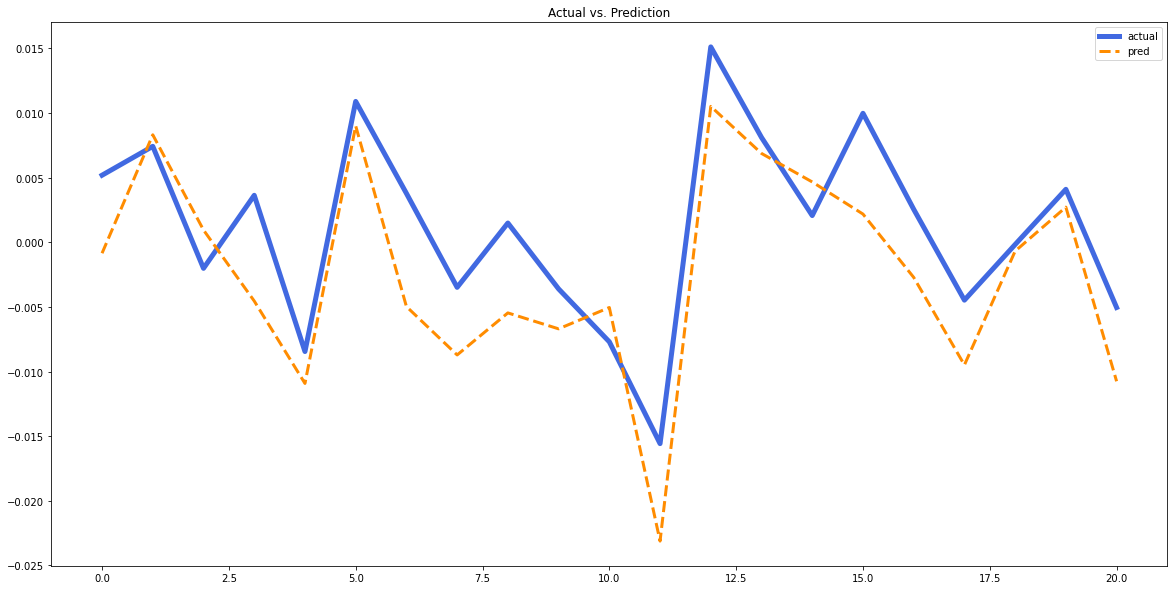

In [60]:
plt.figure(figsize = (20, 10))
plt.plot(np.arange(long_only_df.shape[0]), long_only_df['ret'], label = 'actual', linestyle="-", linewidth=5, color = 'royalblue')
plt.plot(np.arange(long_only_df.shape[0]), long_only_df['y_pred_xgb'], label = 'pred', linestyle="--", linewidth=3, color = 'darkorange')
plt.title("Actual vs. Prediction")
plt.legend()
plt.show()

In [61]:
print("29-day holding period return: {:.2f}%, which is {:.2f}% on a daily basis."
      .format((4389.5-4310.75)/4310.75*100, (4389.5-4310.75)/4310.75*100/29))
print("29-day xgboost return: {:.2f}%, which is {:.2f}% on a daily basis."
      .format(np.sum(long_only_df['g/l'])/4310.75*100, np.sum(long_only_df['g/l'])/4310.75*100/29))

29-day holding period return: 1.83%, which is 0.06% on a daily basis.
29-day xgboost return: 2.32%, which is 0.08% on a daily basis.
